In [4]:
##########A few I/O tests with compressed and uncompressed datasets#################
##### test - 2 ######
import numpy as np
import os 
import sys
import h5py
import timeit
# sys.path.append(os.path.realpath("/nfshome/dawit/compression_test/Triforce_CaloML/Loader"))
# import loader
import glob

def file_size(file_path):
    size = os.stat(file_path).st_size
    return size/1000000.0

def timer(test_code, setup, iter_num):
    total_access_time = timeit.Timer(stmt=test_code, 
                                  setup=setup).timeit(number=iter_num)
    return (total_access_time/iter_num)

def access_epf(files, data_dict, events_per_file):
    features = ['ECAL', 'HCAL', 'pdgID', 'ECAL_E', 'HCAL_E', 'HCAL_ECAL_ERatio', 'energy', 'eta', 'recoEta', 'phi', 'recoPhi', 'openingAngle']
    for feat in features:
        for file in files:
            if feat in file.keys():
                data_dict[file.filename+'-'+feat] = np.array(file[feat][:events_per_file])

In [2]:
# prepare variables for test
data_dict = {}
files = []
time = [] # list of tupels (comp_level, epf, access_time)
iter_num = 1
epf = 0
dataset_path = "/data/shared/LCDLargeWindow/fixedangle/ChPiEscan/"

In [4]:
# recompress everything ones to ../test2 dir
def compress():
    for comp_level in [0,3,4]:
        for i in range(1,5):
            decomp_path = os.path.join(dataset_path,
                                'test2/test2_decomp_%d.h5'%i)

            out_path = os.path.join(dataset_path,
                                'test2/test2_recomp_%d_%d.h5'%(comp_level, i))
            # recompress file to given compression level
            cmd = "h5repack -v -f GZIP=%d %s %s"%(comp_level, decomp_path, out_path)
            os.system(cmd)
    print("finished compressing files.")

compress()

finished compressing files.


In [5]:
# run tests
data_dict = {}
files = []
time = [] # list of tupels (comp_level, epf, access_time)
iter_num = 1
epf = 0
for comp_level in [0,3,4]:
    for i in range(1,5):
        out_path = os.path.join(dataset_path,
                        'test2/test2_recomp_%d_%d.h5'%(comp_level,i))
        comp_file = h5py.File(out_path, 'r')
        files.append(comp_file)
    # open current comp_level files
    for events in [1000, 2000, 5000, 10000]:
        epf = events
        
        setup = "from __main__ import files, data_dict, epf, access_epf"
        test_code = "access_epf(files, data_dict, epf)"
            
        # run test and record data 
        tm = (comp_level, epf, timer(test_code, setup, iter_num))
        # print stat. 
        print("comp_level:%d , epf:%d , time:%.2f"%(tm[0], tm[1], tm[2]))
        time.append(tm)

        data_dict = {} #clear buffer before next eps test.
        
    files = [] # clear files buffer before next eps test.

comp_level:0 , epf:1000 , time:8.08
comp_level:0 , epf:2000 , time:16.01
comp_level:0 , epf:5000 , time:37.63
comp_level:0 , epf:10000 , time:98.26
comp_level:3 , epf:1000 , time:15.96
comp_level:3 , epf:2000 , time:31.25
comp_level:3 , epf:5000 , time:69.16
comp_level:3 , epf:10000 , time:136.18
comp_level:4 , epf:1000 , time:20.21
comp_level:4 , epf:2000 , time:38.80
comp_level:4 , epf:5000 , time:84.27
comp_level:4 , epf:10000 , time:160.29


In [6]:
# save result as a numpy array at ../comp_test2_result.npy
result = np.array(time)
np.save(dataset_path+"test2/comp_test2_result.npy", result)

In [7]:
# load the reults numpy array 
result = np.load(dataset_path+"test2/comp_test2_result.npy")
# print(result)

In [8]:
# make result array plottable . 
comp_level = [0,3,4]
epf = [1000, 2000, 5000, 10000]

comp_0 = result[:4]
comp_3 = result[4:8]
comp_4 = result[8:]

# def sum_four(lst):
#     temp = 0
#     summ = []
#     for i, res in enumerate(lst):
#         if (i % 4) == 3:
#             temp += res[3]
#             summ.append(temp)
#             temp = 0
#         else:
#             temp += res[3]
#     return summ

# comp_0_tt = sum_four(comp_0) #total time for different epf values comp_0_tt[0] ~ epf = 1000
# comp_3_tt = sum_four(comp_3)
# comp_4_tt = sum_four(comp_4)

print(comp_0)
print(comp_3)
print(comp_4)

[[0.00000000e+00 1.00000000e+03 8.08006675e+00]
 [0.00000000e+00 2.00000000e+03 1.60134633e+01]
 [0.00000000e+00 5.00000000e+03 3.76344055e+01]
 [0.00000000e+00 1.00000000e+04 9.82624602e+01]]
[[3.00000000e+00 1.00000000e+03 1.59582749e+01]
 [3.00000000e+00 2.00000000e+03 3.12523446e+01]
 [3.00000000e+00 5.00000000e+03 6.91647528e+01]
 [3.00000000e+00 1.00000000e+04 1.36184862e+02]]
[[4.00000000e+00 1.00000000e+03 2.02079284e+01]
 [4.00000000e+00 2.00000000e+03 3.88019124e+01]
 [4.00000000e+00 5.00000000e+03 8.42679996e+01]
 [4.00000000e+00 1.00000000e+04 1.60286978e+02]]


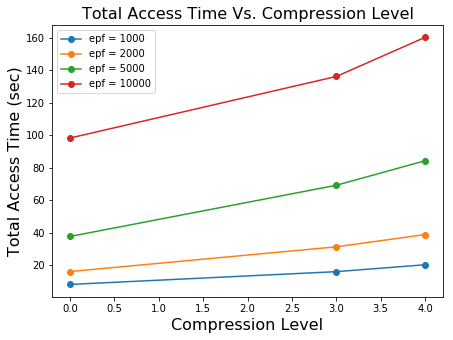

In [12]:
import matplotlib.pyplot as plt

fig_tt = plt.figure(figsize=(7,5))
plt.xlabel('Compression Level', size=16)
plt.ylabel('Total Access Time (sec)', size=16)
plt.title('Total Access Time Vs. Compression Level', size=16)
plt.plot(comp_level, [comp_0[0][2],comp_3[0][2],comp_4[0][2]], '-o', label='epf = 1000')
plt.plot(comp_level, [comp_0[1][2],comp_3[1][2],comp_4[1][2]], '-o', label='epf = 2000')
plt.plot(comp_level, [comp_0[2][2],comp_3[2][2],comp_4[2][2]], '-o', label='epf = 5000')
plt.plot(comp_level, [comp_0[3][2],comp_3[3][2],comp_4[3][2]], '-o', label='epf = 10000')
plt.legend(loc='best')
plt.show()
fig_tt.savefig('ttvcl.png', bbox_inches='tight')
## epf is number of events accessed per file. 

In [ ]:
print(comp_3[8:12])

In [13]:
# # file access order vs access time for comp_level = 3
# order = [1,2,3,4]

# fig_order = plt.figure()
# plt.xlabel('File Access Order', size=16)
# plt.ylabel('Access Time (sec)', size=16)
# plt.title('Access Time Vs. File Access Order', size=16)
# plt.plot(order, [x[3] for x in comp_3[:4]], '-o', label='epf = 1000')
# plt.plot(order, [x[3] for x in comp_3[4:8]], '-o', label='epf = 2000')
# plt.plot(order, [x[3] for x in comp_3[8:12]], '-o', label='epf = 5000')
# plt.plot(order, [x[3] for x in comp_3[12:16]], '-o', label='epf = 10000')
# plt.text(1.0, 20, 'comp_level = 3', size=14)
# plt.legend(loc=9, bbox_to_anchor=(1.2, 1))
# fig_order.savefig('tvo.png', bbox_inches='tight')
# plt.show()
# # file access order is the order in which a file is accessed, 
# # 1st, 2nd, 3rd and 4th
# # looks like the 4th file access is just as fast as the other 3.

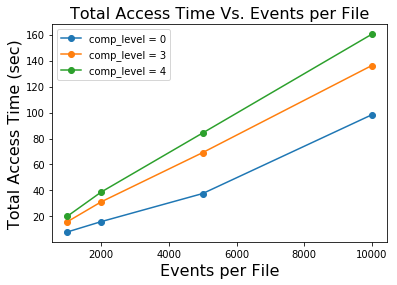

In [14]:
# total access time vs epfs 
fig_epf = plt.figure()
plt.xlabel('Events per File', size=16)
plt.ylabel('Total Access Time (sec)', size=16)
plt.title('Total Access Time Vs. Events per File', size=16)
plt.plot(epf, [res[2] for res in comp_0], '-o', label='comp_level = 0')
plt.plot(epf, [res[2] for res in comp_3], '-o', label='comp_level = 3')
plt.plot(epf, [res[2] for res in comp_4], '-o', label='comp_level = 4')
plt.legend(loc='best')
fig_epf.savefig('ttvepf.png', bbox_inches='tight')
plt.show()
# for epf = 2000 and 1000 no drastic difference between different comp_level values. 